In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from tqdm import tqdm
import tensorflow as tf

sys.path.append('../../ieegpy/ieeg')
sys.path.append('code/tools')
sys.path.append('code')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import keras as K


# sets path to one directory up from where code is
path = "/".join(os.path.abspath(os.getcwd()).split('/')[:-1])

import json
import numpy as np
import pandas as pd
from get_iEEG_data import get_iEEG_data
from plot_iEEG_data import plot_iEEG_data
from line_length import line_length
from get_iEEG_duration import get_iEEG_duration
import csv_utils
import segmentation
import feature_extraction
import preprocess

In [3]:
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 74678402906678912
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6938689536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13730041367843082587
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:2d:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [5]:
with open("credentials.json") as f:
    credentials = json.load(f)
    username = credentials['username']
    password = credentials['password']

In [6]:
metadata = pd.read_csv('ieeg_metadata.csv')
metadata.describe()

,Unnamed: 0,Seizure number,Seizure EEC,Seizure UEO,Seizure end,Seizure duration
count,256.000000,256.000000,2.560000e+02,2.560000e+02,2.560000e+02,256.000000
mean,161.523438,3.808594,3.850046e+05,3.850087e+05,3.850987e+05,89.983726
std,105.468253,4.411047,2.512188e+05,2.512184e+05,2.512276e+05,107.030035
min,0.000000,0.000000,1.422600e+04,1.422600e+04,1.425995e+04,4.900000
25%,64.750000,1.000000,2.076900e+05,2.076916e+05,2.077277e+05,34.252500
50%,155.500000,2.000000,3.487700e+05,3.487708e+05,3.490025e+05,67.945000
75%,255.250000,5.000000,5.301436e+05,5.301436e+05,5.302733e+05,91.760000
max,364.000000,22.000000,1.694568e+06,1.694570e+06,1.694644e+06,781.950000


In [7]:
seizure_data = csv_utils.read_pickle('data/seizure/seizure_clips_data', 256)
seizure_time = csv_utils.read_pickle('data/seizure_time/seizure_time_data', 256)
for i in range(len(seizure_data)):
    seizure_data[i] = seizure_data[i].dropna(axis='columns')

In [8]:
nonseizure_data = csv_utils.read_pickle('data/non_seizure/nonseizure_clips_data', 256)
nonseizure_time = csv_utils.read_pickle('data/non_seizure_time/nonseizure_time_data', 256)
for i in range(len(nonseizure_data)):
    nonseizure_data[i] = nonseizure_data[i].dropna(axis='columns')

In [9]:
# seizure_data,seizure_time = csv_utils.seizure_clip_read(metadata, username, password)
# csv_utils.dump_pickle(seizure_data,'data/seizure/seizure_clips_data')
# csv_utils.dump_pickle(seizure_time,'data/seizure_time/seizure_time_data')

In [10]:
# nonseizure_data, nonseizure_time = csv_utils.nonseizure_clip_read(metadata, username, password)
# csv_utils.dump_pickle(nonseizure_data,'data/non_seizure/nonseizure_clips_data')
# csv_utils.dump_pickle(nonseizure_time,'data/non_seizure_time/nonseizure_time_data')

In [11]:
window_len = 2
stride = 1
seizure_data_windowed = []
for i in tqdm(range(len(seizure_data))):
    fs = segmentation.get_fs(seizure_time[i])
    if fs == 512:
        seg = segmentation.get_windoweds(seizure_data[i].to_numpy(), fs, window_len, stride)
        seizure_data_windowed.append(seg)
window_len = 2
stride = 1
nonseizure_data_windowed = []
for i in tqdm(range(len(nonseizure_data))):
    fs = segmentation.get_fs(nonseizure_time[i])
    if fs == 512:
        seg = segmentation.get_windoweds(nonseizure_data[i].to_numpy(), fs, window_len, stride)
        nonseizure_data_windowed.append(seg)

100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [00:29<00:00,  8.58it/s]


In [12]:
seizure_data_windowed[1].shape

(78, 1024, 82)

In [13]:
channel_n = 90
fs = 512
seizure_data_stack = np.empty((0, fs * 2, channel_n))
for c in seizure_data_windowed:
    if c.shape[2] == channel_n:
        seizure_data_stack = np.vstack((seizure_data_stack, c))
for c in nonseizure_data_windowed:
    if c.shape[2] == channel_n:
        seizure_data_stack = np.vstack((seizure_data_stack, c))

In [14]:
seizure_data_stack.shape

(2192, 1024, 90)

In [15]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, BatchNormalization,GlobalAveragePooling2D, Input, Reshape, UpSampling2D
from keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.optimizers import schedules, SGD, Adam
import tensorflow as tf
from sklearn import preprocessing
from matplotlib import pyplot as plt

In [16]:
dg_min, dg_max = preprocess.normalization_fit_stack(seizure_data_stack)
seizure_data_norm = preprocess.normalize_stack(seizure_data_stack,dg_min,dg_max)

In [17]:
from keras import backend as K
K.clear_session()

In [18]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [19]:
from autoencoder import Autoencoder
ae = Autoencoder(seizure_data_stack.shape[1],seizure_data_stack.shape[2])

In [20]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",restore_best_weights=True)
ae.build(input_shape = (None,seizure_data_norm.shape[1],seizure_data_norm.shape[2]))
ae.summary()
opt = keras.optimizers.Adam(learning_rate=0.00005)
ae.compile(optimizer=opt, loss='mse')
ae.fit(seizure_data_norm, seizure_data_norm,
          epochs=100,
          batch_size=16,callbacks = [callback],
          validation_data=(seizure_data_norm, seizure_data_norm))

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 1, 128)       12576     
                                                                 
 sequential_1 (Sequential)   (None, 1024, 90)          14529     
                                                                 
Total params: 27,105
Trainable params: 26,593
Non-trainable params: 512
_________________________________________________________________
Epoch 1/100
137/137 [==============================] - 16s 88ms/step - loss: 0.1659 - val_loss: 0.0925
Epoch 2/100
137/137 [==============================] - 11s 78ms/step - loss: 0.0142 - val_loss: 0.0328
Epoch 3/100
137/137 [==============================] - 11s 78ms/step - loss: 0.0102 - val_loss: 0.0135
Epoch 4/100
137/137 [==============================] - 11s 78ms/step - loss: 0.0084 - val_loss: 0.0179
Epoch 5/100
137/137 [============

In [28]:
ae.encoder.save("encoder.h5")
ae.decoder.save("decoder.h5")

In [29]:
encode = ae.encoder.predict(seizure_data_norm)
decode = ae.decoder.predict(encode)

69/69 [==============================] - 1s 16ms/step


In [30]:
decode.shape

(2192, 1024, 90)

In [31]:
from sklearn.metrics import mean_squared_error
mean_squared_error(seizure_data_norm[3], decode[3])

0.0013828236203501235

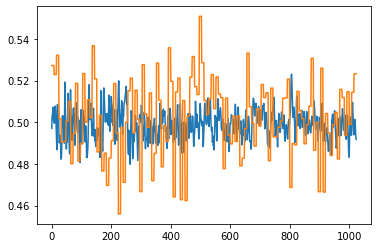

In [54]:
plt.plot(seizure_data_norm[10,:,0])
plt.plot(decode[10,:,0])

In [33]:
decode[0].max()

0.6048561

In [35]:
encode = encode[:,:,0,:]

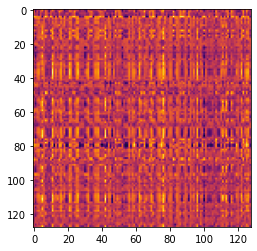

In [68]:
plt.imshow(encode[800], cmap='inferno')
plt.show()

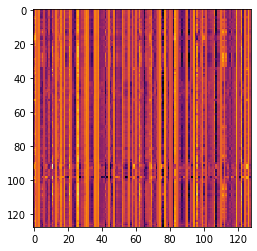

In [67]:
plt.imshow(encode[1500], cmap='inferno', interpolation='nearest')
plt.show()